# Exercise 7: Robust Model Fitting

## Helper Functions


In [73]:
import numpy as np
import cv2 
import os
import scipy
import matplotlib.pyplot as plt
import matplotlib
import skimage

def load_im(path : str) -> np.ndarray:
    """
        Returns:
            Image scaled to float.
    """
    im = cv2.imread(path)[:, :, ::-1]
    im = im.astype(np.float64) / 255
    
    return im


def pi(points : np.ndarray) -> np.ndarray:
    """
        Converts from homogeneous to inhomogeneous coordinates
    """
    p = points[:-1]/points[-1]
    
    return p


def piInv(points : np.ndarray) -> np.ndarray:
    """
        Converts from inhomogeneous to homogeneous coordinates
    """
    
    # Gets the amount of points by using shape
    _, num_points = points.shape
    
    # Stacks the scale s at the bottom of the matrix
    ph = np.vstack((points, np.ones(num_points)))
    
    return ph


def projectPoints(K, Rt, Q):
    
    Q_hom = piInv(Q)
    points = K @ Rt @ Q_hom
    points_inhom = pi(points)
    
    return points_inhom


def hest(q1, q2) -> np.ndarray:
    """
        Takes two points in 2D and returns the estimated homography matrix.
    """
    
    if len(q1) != len(q2):
        raise ValueError("There must be an equal amount of points in the two sets!")
    
    Bi = []
    for i in range(q1.shape[1]):
        qi = q1[:,i]   # <-- getting the first column
        
        # Creating that weird qx matrix for the Kronecker product
        q1x = np.array(
            [[0,        -1, qi[1]],
             [1,        0, -qi[0]],
             [-qi[1], qi[0], 0]]
        )
        
        q2t_hom = q2[:, i].reshape(-1, 1) # <-- getting the first column and reshaping does for dim: (1, ) -> (1,1)
        Bi.append(np.kron(q2t_hom.T, q1x)) # <-- formula follows that of week 2, slide 56
        # print(np.kron(q2t_hom.T, q1x).shape)
       
    B = np.concatenate(Bi, axis=0)
    
    # Some TA prooved that it was unneseccary to find their dot product
    #BtB = B.T @ B
    V, Lambda, Vt = np.linalg.svd(B)
    Ht = Vt[-1, :]
    
    Ht = np.reshape(Ht, (3, 3))
    H = Ht.T
    
    return H
    
    
def crossOp(p : np.ndarray) -> np.ndarray:
    """
        One of Them weird functions. It takes in a 3D vector and then returns
        some gnarly matrix.
    """
    p = p.flatten()
    if p.size != 3:
        raise Exception("Invalid input, vector must be exactly 3D.")
    
    x, y, z = p
    px = np.array(
        [[0, -z, y],
         [z, 0, -x],
         [-y, x, 0]]
    )
    
    return px


def computeFundamentalMatrix(K1 : np.ndarray, K2 : np.ndarray, R2 : np.ndarray, t2 : np.ndarray) -> np.ndarray:
    """
        Computing the fundamental matrix between two camera matrices K1 & K2.
    """
    t2x = crossOp(t2)

    E = t2x @ R2

    K1inv = np.linalg.inv(K1)
    K2inv = np.linalg.inv(K2)

    F = K1inv.T @ E @ K2inv
    
    return F


def fancyRotate(theta_x, theta_y, theta_z):
    """
        Does the rotation matrix that we have seen a few times.
        E.g. Exercises week 4, eq(12).
    """
    from scipy.spatial.transform import Rotation
    
    R = Rotation.from_euler("xyz", [theta_x, theta_y, theta_z]).as_matrix()
    
    return R


def in_frame(l, l_im, shape):
    """
        I think this checks whether the line is within the image
    """
    q = np.cross(l.flatten(), l_im)
    q = q[:2]/q[2]
    if all(q >= 0) and all(q+1 <= shape[1::-1]):
        return q
    
def DrawLine(l, shape):
    """
        Checks where the line intersects the four sides of the image
        and finds the two intersections that are within the frame
    """
    lines = [[1, 0, 0], [0, 1, 0], [1, 0, 1-shape[1]], [0, 1, 1-shape[0]]]
    P = [in_frame(l, l_im, shape) for l_im in lines if in_frame(l, l_im, shape) is not None]
    plt.plot(*np.array(P).T)

def draw_line_Vitus(line: np.ndarray, tau: float):
    """
        Draws a line with a width of tau.
        
        Takes:
            :param line: The line to be drawn
            :param tau: The distance from the line to be drawn
        
        Returns:
            :return: None
    """
    
    x1, x2 = plt.gca().get_xlim()
    y1 = -(line[0]*x1 + line[2]) / line[1]
    y2 = -(line[0]*x2 + line[2]) / line[1]
    y1_low = -(line[0]*x1 + line[2] + tau) / line[1]
    y1_high = -(line[0]*x1 + line[2] - tau) / line[1]
    y2_low = -(line[0]*x2 + line[2] + tau) / line[1]
    y2_high = -(line[0]*x2 + line[2] - tau) / line[1]
    
    plt.axline((x1,y1), (x2,y2), c='black')
    plt.axline((x1,y1_low), (x2,y2_low), c='black', linestyle='dashed')
    plt.axline((x1,y1_high), (x2,y2_high), c='black', linestyle='dashed')
    



## Ex 7.1

Load the image and detect edges in it. Here the function `cv2.Canny` can be used. Visualize the edges you have detected.

### Response

The path: ../Data/Week_06/data/Box3.bmp 
Exists: True


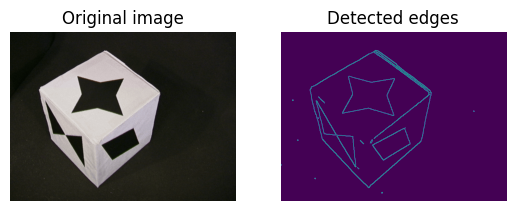

In [12]:
PATHBOX3 = "../Data/Week_06/data/Box3.bmp"
print(f"The path: {PATHBOX3} \nExists: {os.path.exists(PATHBOX3)}")
img_float = load_im(PATHBOX3)
img_int = (img_float*255).astype(np.uint8)

edges = cv2.Canny(img_int, 100, 200)

plt.subplot(1, 2, 1)
plt.imshow(img_int)
plt.title("Original image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edges)
plt.title("Detected edges")
plt.axis("off")

plt.show()



## Ex. 7.2
Compute the Hough space from the detected edges. Use the function:

`hspace, angles, dists = skimage.transform.hough_line(edges)`

What do the returned values `hspace, angles, dists` mean?

### Response

In [14]:
hspace, angles, dists = skimage.transform.hough_line(edges)


I did good!

## Ex. 7.3

Visualize the Hough space. To get the correct units on the axes you can use:

`extent = [angles[0], angles[-1], dists[-1], dists[0]]`

`plt.imshow(hspace, extent=extent, aspect="auto")`


### Response

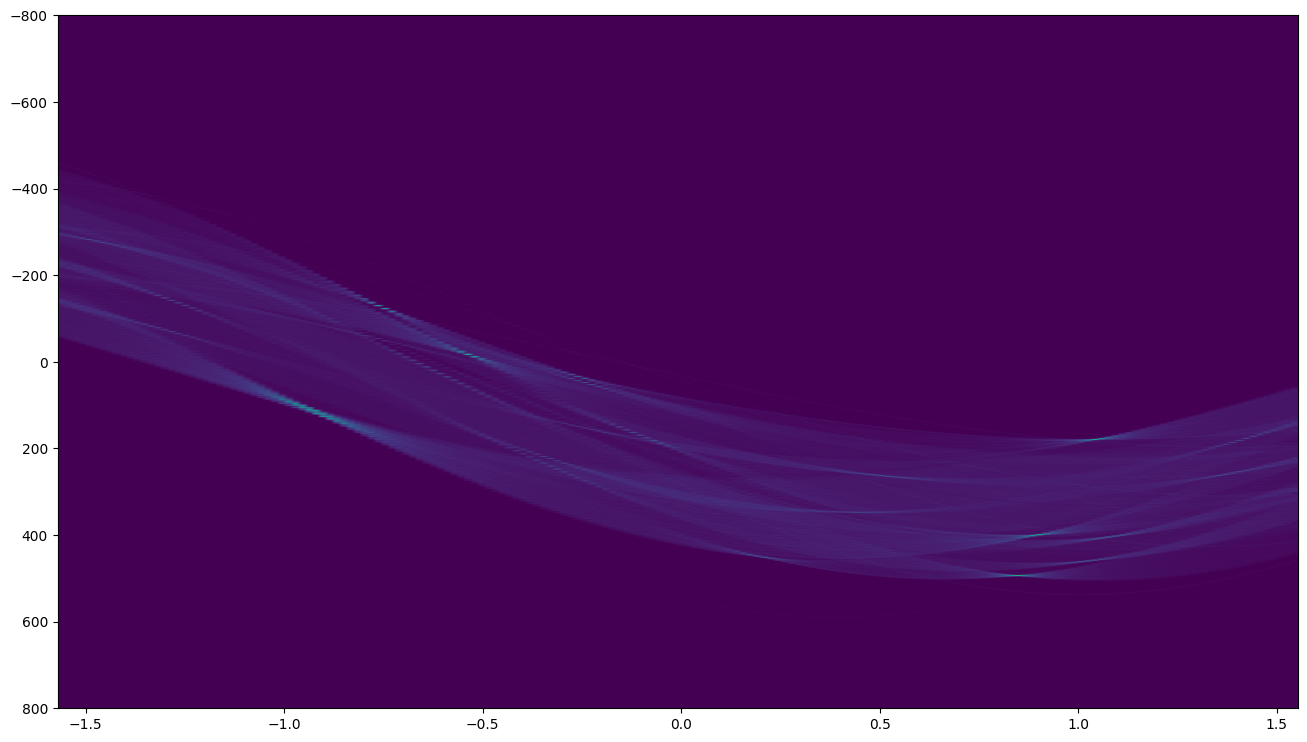

In [15]:
extent = [angles[0], angles[-1], dists[-1], dists[0]]

plt.figure(figsize=(16, 9))
plt.imshow(hspace, extent=extent, aspect="auto")
plt.show()

## Ex. 7.4

Find peaks in your Hough space, using `skimage.transform.hough_line_peaks`.

`extH, extAngles, extDists = hough_line_peaks(hspace, angles, dists, num_peaks=n)`

Display your identified peaks on top of the Hough space.

### Response

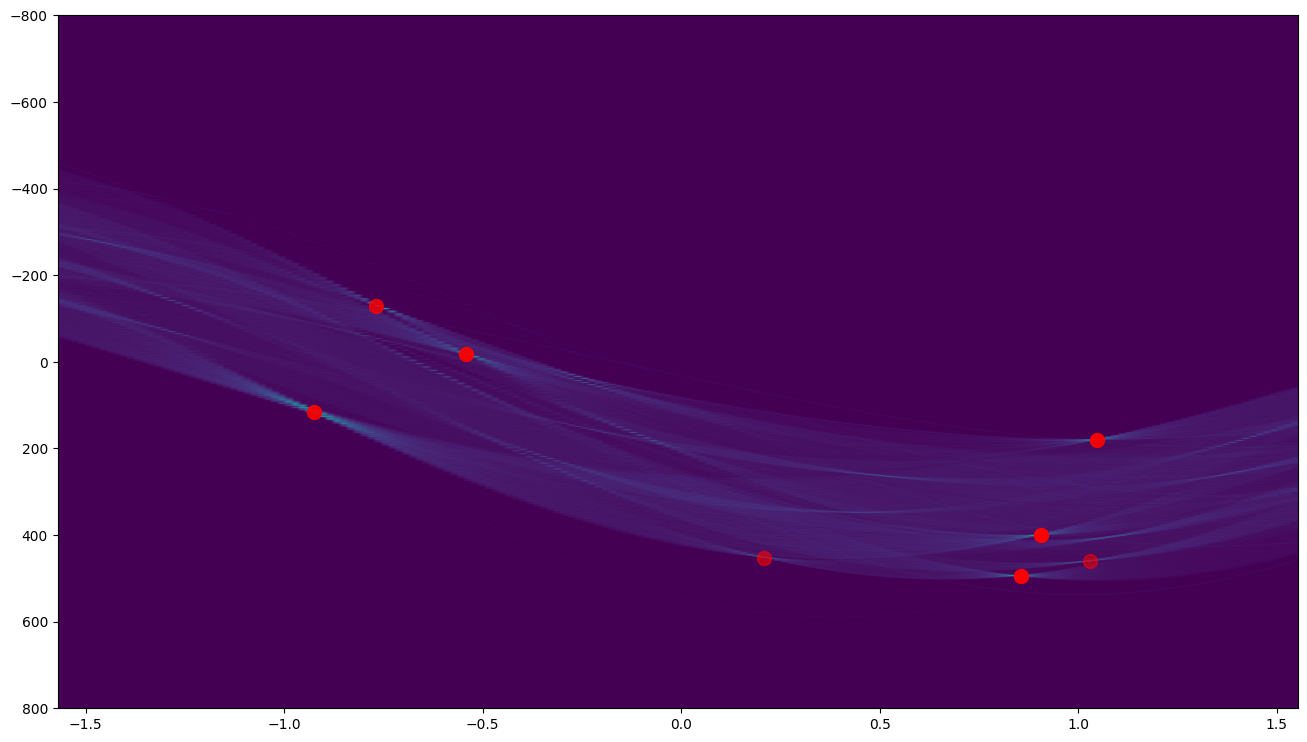

In [18]:
n = 10
extH, extAngles, extDists = skimage.transform.hough_line_peaks(hspace, angles, dists, num_peaks=n)

extH_stand = extH / np.max(extH)

plt.figure(figsize=(16, 9))
plt.imshow(hspace, extent=extent, aspect="auto")
for i in range(len(extH_stand)):
    plt.scatter(extAngles[i], extDists[i], alpha=extH_stand[i], s=100, c="red")

plt.show()
    



Alternative solution:

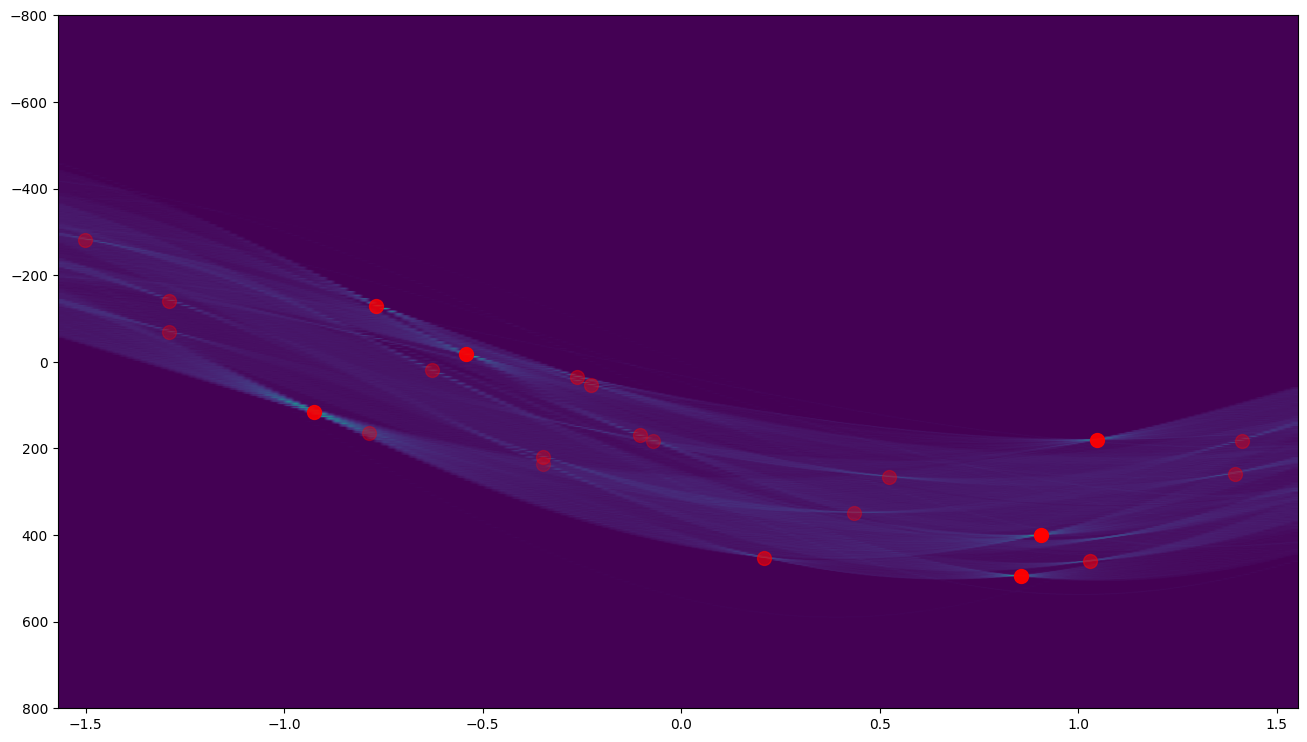

In [19]:
tau = 0.25 * np.max(hspace)
extH2, extAngles2, extDists2 = skimage.transform.hough_line_peaks(hspace, angles, dists, threshold=tau)

extH_stand2 = extH2 / np.max(extH2)

plt.figure(figsize=(16, 9))
plt.imshow(hspace, extent=extent, aspect="auto")
for i in range(len(extH_stand2)):
    plt.scatter(extAngles2[i], extDists2[i], alpha=extH_stand2[i], s=100, c="red")

plt.show()
    



# Ex. 7.5
Draw the lines that correspond to the identified peaks on top of your original image. For this you
can use the `DrawLine` function from week 3 (repeated below - *It was scuffed, so I made my own*).




### Response

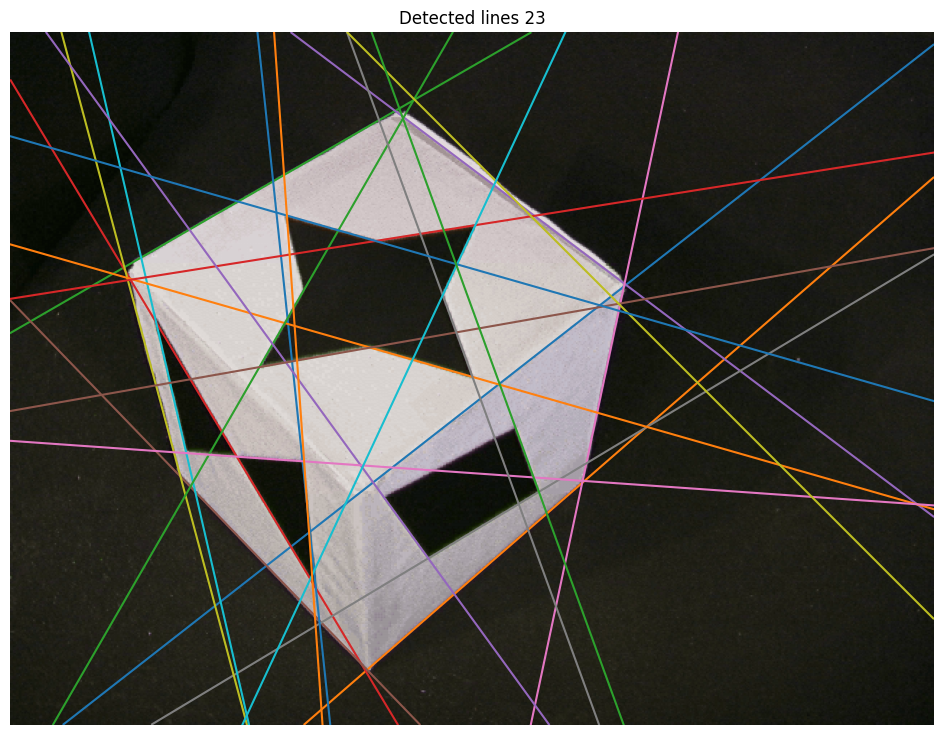

In [26]:
# Once again this course boils down to getting an array into the correct shape    
l = np.asarray([np.cos(extAngles2), np.sin(extAngles2), -extDists2]).T

plt.figure(figsize=(16, 9))
plt.title(f"Detected lines {len(l)}")
plt.imshow(img_int)
for line in l:
    DrawLine(line, img_int.shape)

plt.axis("off")
plt.show()

Alternative response (which was the original response)

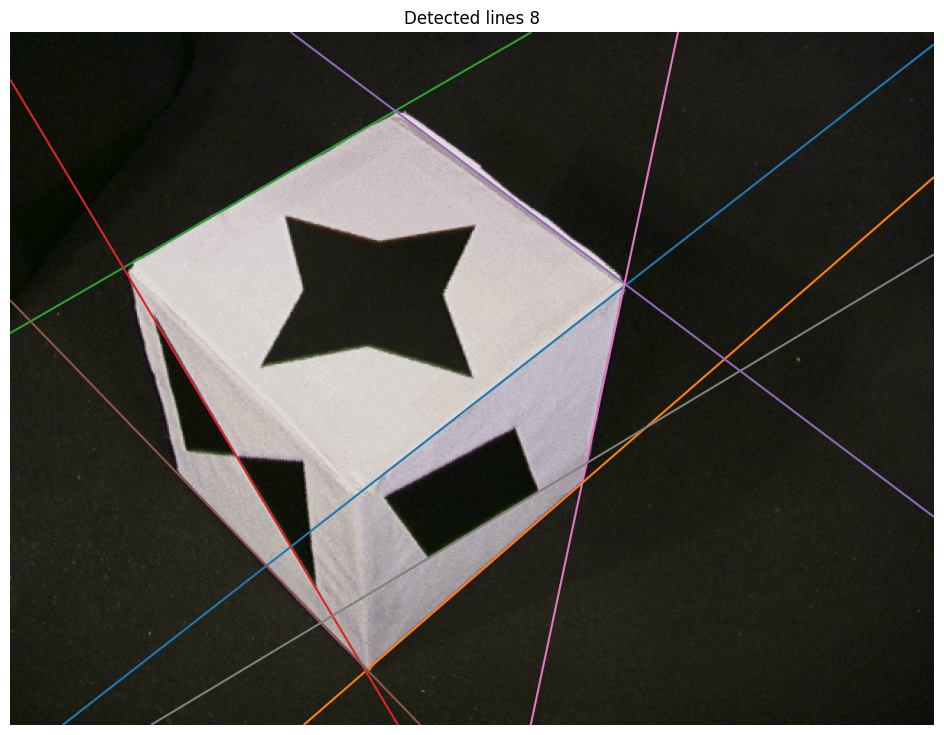

In [27]:
l = np.asarray([np.cos(extAngles), np.sin(extAngles), -extDists]).T

plt.figure(figsize=(16, 9))
plt.title(f"Detected lines {len(l)}")
plt.imshow(img_int)
for line in l:
    DrawLine(line, img_int.shape)

plt.axis("off")
plt.show()

## Ex. 7.6
Make a function that estimates a line, in homogeneous coordinates, given two points.

### Response


In [75]:
def line_estimate(p1: np.ndarray, p2: np.ndarray) -> np.ndarray:
    """
        Takes:
            :param p1: A 2D point in homogenous coordinates
            :param p2: A 2D point in homogenous coordinates
        
        Returns:
            The line estimate between the two points
    """
    
    line_estimate = np.cross(p1, p2)
    
    # divide the first two coordinates by their own norm
    line_estimate = line_estimate / np.linalg.norm(line_estimate[:2])
    
    return line_estimate
    

## Ex. 7.7

Make a function that determines which of a set of **2D** points are a inliers or outlier with respect
to a given line. The threshold should be supplied as parameter to this function, such that it can
easily be tuned later.

### Response


In [76]:
def determine_inliers(l: np.ndarray, points: np.ndarray, tau: float) -> np.ndarray:
    """
        Takes:
            :param l: A line estimate in homogenous coordinates
            :param points: A set of points in homogenous coordinates
            :param tau: The threshold to determine whether a point is an inlier
        
        Returns:
            A boolean array of the same length as points, where True indicates that the point is an inlier
    """
    # Compute the distance between the line and the points
    distances = np.abs(l @ points)
    
    # Determine which points are within the threshold
    inliers = distances < tau
    
    
    return inliers

## Ex. 7.8
Make a function that calculates the consensus, i.e. the number of inliers, for a line with respect to a set of points.

### Response

In [77]:
def consensus(l: np.ndarray, points: np.ndarray, tau: float) -> int:
    """
        Takes:
            :param l: A line estimate in homogenous coordinates
            :param points: A set of points in homogenous coordinates
            :param tau: The threshold to determine whether a point is an inlier
        
        Returns:
            The number of inliers
    """
    
    inliers = determine_inliers(l, points, tau)
    num_inliers = np.sum(inliers)
    
    return num_inliers

## Ex. 7.9
Make a function that randomly draws two of n 2D points.

### Response

In [101]:
def draw_2_points_random(points : np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
        Takes:
            :param points: A set of points in homogenous coordinates

        Returns:
            Two points chosen at random from the set of points
    """
    
    n = 2
    
    index = np.random.choice(points.shape[1], n, replace=False)
    
    two_points = (points[:, index[0]], points[:, index[1]])
    
    return two_points
    

## Ex. 7.10
Assemble the functions made above to a working RANSAC algorithm for estimating lines. Set the number of iterations and the threshold manually.

### Response

In [102]:
def RANSAC(points: np.ndarray, tau: float, epsilon: float = 0.1, p : float = 0.99):
    """
        Takes:
            :param points: A set of points in homogenous coordinates
            :param tau: The threshold to determine whether a point is an inlier
            :param epsilon: The probability that a point is an outlier
            :param p: The probability that we find a good model
        
        Returns:
            The best line estimate found by RANSAC
    """
    
    # total number of datapoints
    m = len(l)
    
    n = 2
    
    # Number of inliers found in the best model so far
    s = 0
    
    N = np.log(1 - p) / (np.log(1 - (1 - epsilon)**m))
    
    counter = 0
    
    best_line = None
    
    while counter < N:
        
        # Draw two random points
        rand_points = draw_2_points_random(points)
        
        # Creating the line that goes through the two points
        l = line_estimate(rand_points[0], rand_points[1])
        
        # Determine the number of inliers
        inliers = consensus(l, points, tau)
        
        if inliers > s:
            s = inliers
            best_line = l
        
        # epsilon_hat
        epsilon = 1 - s/m
        
        # N_hat
        N = np.log(1 - p) / (np.log(1 - (1 - epsilon)**n))
        
        # So that we don't stay inside the loop indefinitely
        counter += 1
    
    return best_line
        
    

Bad solution, where we set number of iterations and threshold manually

In [103]:
def RANSAC_plep(points: np.ndarray, tau: float, N : int = 100):
    """
        Takes:
            :param points: A set of points in homogenous coordinates
            :param tau: The threshold to determine whether a point is an inlier
            :param N: The number of iterations
        
        Returns:
            The best line estimate found by RANSAC
    """
    # Number of inliers found in the best model so far
    s = 0
    
    counter = 0
    
    best_line = None
    
    while counter < N:
        
        # Draw two random points
        rand_points = draw_2_points_random(points)
        
        # Creating the line that goes through the two points
        l = line_estimate(rand_points[0], rand_points[1])
        
        # Determine the number of inliers
        inliers = consensus(l, points, tau)
        
        if inliers > s:
            s = inliers
            best_line = l
        
        # So that we don't stay inside the loop indefinitely
        counter += 1
    
    print(f"Best number of inliers found: {s}")
    
    return best_line

#### Testing it


Best number of inliers found: 56


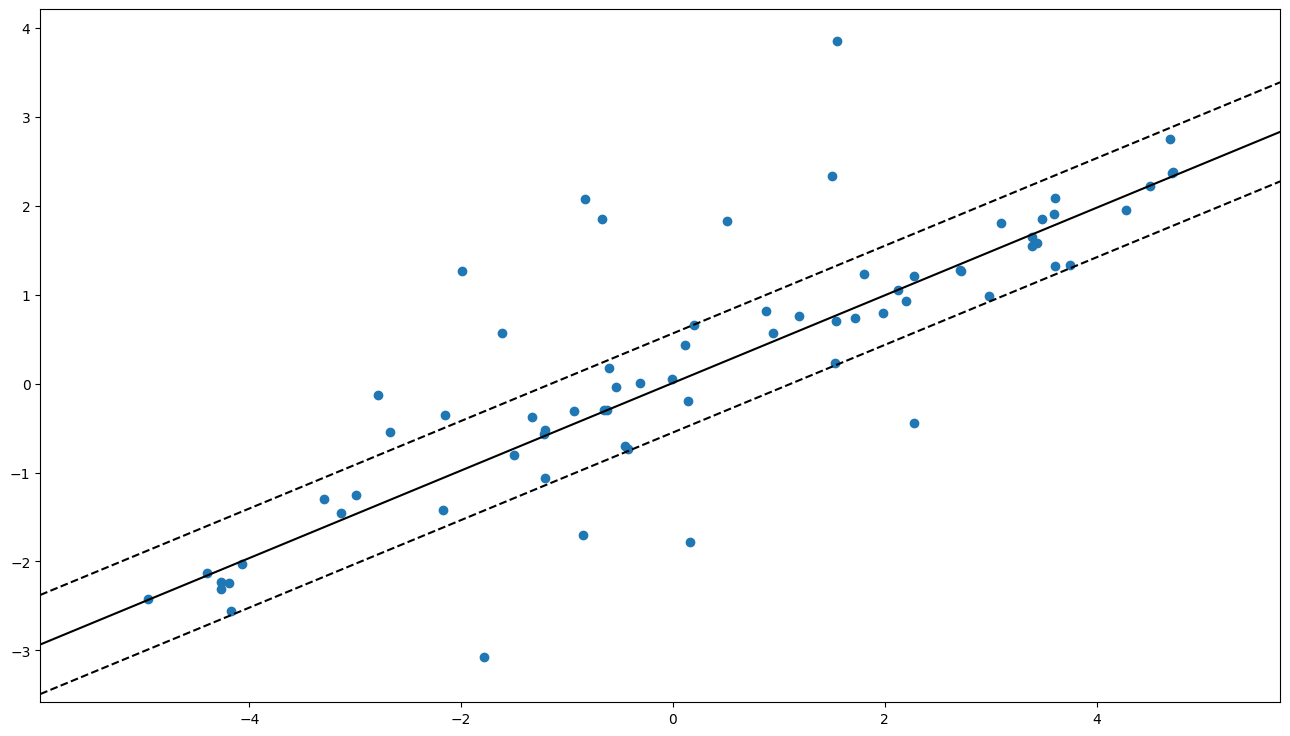

In [108]:
def test_points(n_in, n_out):
    """
        One of Mortens wild functions...
    """
    a = (np.random.rand(n_in) - .5)*10
    b = np.vstack((a, a*.5 + np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

points = test_points(50, 20)
points_hom = piInv(points)
tau = .5
best_line = RANSAC_plep(points_hom, tau=tau, N=10000)

plt.figure(figsize=(16, 9))
plt.scatter(points[0], points[1])
draw_line_Vitus(best_line, tau)
plt.show()


## Ex. 7.11

Experiment with the algorithm, what is a good threshold for distinguishing between inliers and outliers?


### Response

## Ex. 7.12

Add the final step to your implementation, where you fit a new line to all inliers of the best line. The total least squares fit of a straight line to a set of points is given by the first principal component of them. Consider using the code below to get a homogeneous line along the first
principal component.

### Response

## Ex. 7.13
mplement the stopping criteria for RANSAC as described on the slides. Use $p = 0.99$.

### Response